# Mining a USAID report
This is a first go at mining a report from a funding body, in this case a report from USAID on. We will try and extract all relevant placenames from the report.

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import os
import PyPDF2
import re

Select the doc you want to analyse

In [2]:
doc = os.path.join('/', 'home', 'peter', 'data', 'Surgo', 'usaid_evaluation_example.pdf')

Define function to extract all the characters from a PDF. 

In [3]:
def extract_text_from_pdf(path):
    pdfFileObj = open(doc,'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    text = ''
    for page in range(0, pdfReader.getNumPages()):
        pageObj = pdfReader.getPage(page)          
        text = text + ' ' + pageObj.extractText()
    return(text)

Extract text form the requested doc

In [4]:
txt = extract_text_from_pdf(doc)

Clean up the raw text by removing any html, linebreaks, and non-letter characters. Then split so we have a list with all the words.

In [51]:
txt_clean = BeautifulSoup(txt, "html5lib").get_text()
txt_clean = re.sub("\n", ' ', txt_clean)
txt_clean = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                       # The pattern to replace it with
                      txt_clean)
txt_clean = txt_clean.lower()
txt_clean_list = txt_clean.split()               # Split into words, i.e. tokenize
print(txt_clean_list[0:50])
print(len(txt_clean_list))

['april', 'this', 'publication', 'was', 'produced', 'for', 'review', 'by', 'the', 'united', 'states', 'agency', 'for', 'international', 'development', 'it', 'was', 'prepared', 'by', 'michele', 'andina', 'robertino', 'mera', 'dipanjan', 'sujit', 'roy', 'and', 'anita', 'rego', 'under', 'the', 'direction', 'of', 'social', 'impact', 'inc', 'with', 'management', 'systems', 'international', 'evaluation', 'aids', 'prevention', 'and', 'control', 'apac', 'evaluation', 'usaid', 'india', 'final']
24597


Download and initialize stopwords

In [52]:
import nltk
nltk_dir = os.path.join('/home', 'peter', 'data', 'nltk')
if nltk_dir not in nltk.data.path:
    nltk.data.path.append(nltk_dir)

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
txt_clean_list = [word for word in txt_clean_list if word not in stop]
print('Number of words after preprocessing (including duplicates): %d ' % len(txt_clean_list))

[nltk_data] Downloading package stopwords to /home/peter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Number of words after preprocessing (including duplicates): 17155 


Create bag of words and term frequency. Now we are ready to screen this list for any geography names. But first we have to get a list of geographic items in India.

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   
                             lowercase = True,
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
# Convert to array. This will be 1xfeatures, or 1xUniqueWords. Select the first row as there is only 1. 
word_counts = vectorizer.fit_transform([' '.join(txt_clean_list)]).toarray()[0]
print('Number of features (unique words) extracted from the text: %d' % len(word_counts))
vocab = vectorizer.get_feature_names()
word_freq = pd.DataFrame({'word': vocab, 'count': word_counts})
print(word_freq.sort_values('count', ascending=False).head(50))

Number of features (unique words) extracted from the text: 3022
      count           word
143     501           apac
892     239     evaluation
1159    232            hiv
1137    221         health
2063    191        project
2682    185          tamil
1700    183           nadu
78      173           aids
739     167      districts
2562    126          state
2697    112           team
2701    111      technical
608     102           data
1553     96     management
2022     93     prevalence
2056     90        program
538      85        control
1094     82     government
1710     79       national
2672     79        systems
2024     77     prevention
1256     76          india
1130     75           hard
2580     73            sti
197      72     assistance
1750     66            non
2864     65          usaid
2643     65        support
334      65           care
989      60         figure
2752     60             ti
1696     59           naco
102      58          among
109      57       

## Load India geonames gazetteer
Downloaded from http://download.geonames.org/export/dump/

In [8]:
# Get the names of columns from the readme file
india_gazetteer = pd.read_csv(
    os.path.join('/home', 'peter', 'data', 'Surgo', 'geonames', 'IN.txt'), 
    sep='\t', 
    low_memory=False,  # otherwise it complains about inconsistent dtype in columns.
    header=None,  # define header names ourselves
    names=['geonameid', 'name', 'asciiname', 'alternatenames', 'latitude', 'longitude', 'feature_class', 
          'feature_code', 'country_code', 'cc2', 'admin1_code', 'admin2_code', 'admin3_code', 'admin4_code',
          'population', 'elevation', 'dem', 'timezone', 'modification_date']
)
# india_gazetteer.describe()
india_gazetteer.head(5)

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature_class,feature_code,country_code,cc2,admin1_code,admin2_code,admin3_code,admin4_code,population,elevation,dem,timezone,modification_date
0,1114940,Rāvi River,Ravi River,"Ravi,Ravi River,Rāvi,Rāvi River",30.62123,71.82683,H,STM,IN,PK,0.0,NaN,NaN,NaN,0,NaN,133,Asia/Karachi,2017-06-06
1,1114942,Punjab Plains,Punjab Plains,Punjab Plains,30.00000,75.00000,T,PLN,IN,NaN,0.0,NaN,NaN,NaN,0,NaN,206,Asia/Kolkata,2012-01-16
2,1114957,Jhelum River,Jhelum River,"Jhelum,Jhelum River,River Hydaspes,Veth River",31.16853,72.15066,H,STM,IN,PK,0.0,NaN,NaN,NaN,0,NaN,147,Asia/Karachi,2017-02-03
3,1114958,Hindustan,Hindustan,"Hindustan,Hindustán",28.00000,76.00000,L,RGN,IN,"IN,PK",0.0,NaN,NaN,NaN,0,NaN,344,Asia/Kolkata,2006-06-23
4,1114965,Basantar River,Basantar River,"Basantar,Basantar Nala,Basantar Nāla,Basantar ...",32.47452,75.01449,H,STM,IN,NaN,0.0,NaN,NaN,NaN,0,NaN,300,Asia/Karachi,2016-03-09


Show that lats and longs make up India and where most locations are recorded in geonames. Hue indicates altitude. There are approx 600k locations in the geonames index, we are sampling a few of them to visualize.

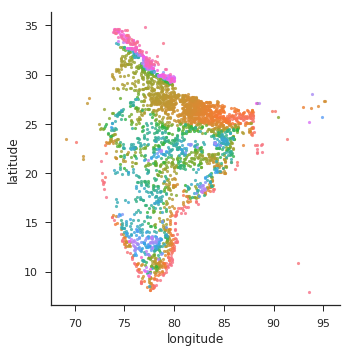

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
%matplotlib inline
ax = sns.lmplot('longitude', # Horizontal axis
           'latitude', # Vertical axis
           data=india_gazetteer.sample(2000), # Data source
           fit_reg=False, # Don't fix a regression line
           hue="dem", # Set color
           legend=False,
           scatter_kws={"marker": "D", # Set marker style
                        "s": 10}) # S marker size

Geonames gives every feature a class (single letter) as well as a feature _code_ which describes a subitem of the class. A full list is described here: http://www.geonames.org/export/codes.html. 

We are only interested in class:

* A - country, state, region
* P - city, village

So let's filter our gazetteer for these. Takes out only about 20% of data points. 

In [13]:
ig = india_gazetteer[india_gazetteer['feature_class'].isin(['A', 'P'])]

We made our list of words lowercase so let's do the same here

In [33]:
# Throws a spurious SettingWithCopyWarning. 
ig.loc[:, 'name_lower'] = ig['name'].apply(str.lower)
print(ig.sample(10))

        geonameid          name     asciiname alternatenames  latitude  \
79509    10180376     Purānābās     Puranabas            NaN  28.34807   
317027   10676045       Pandwāi       Pandwai            NaN  23.85997   
182881   10514930    Dhīmartola    Dhimartola            NaN  21.53619   
394382   10762664    Bhagwānpur    Bhagwanpur            NaN  26.82419   
140578   10470929     Beldongri     Beldongri            NaN  21.34250   
614281   11666048  Kodāngipatti  Kodangipatti            NaN   9.45666   
31125     1432561   Choring Pol   Choring Pol            NaN  33.97378   
24924     1277679         Bākra         Bakra            NaN  22.48196   
122491   10450402   Nasrullābād   Nasrullabad            NaN  18.47667   
206669   10539122       Dugauli       Dugauli            NaN  25.85158   

        longitude feature_class feature_code country_code  cc2  admin1_code  \
79509    75.41608             P          PPL           IN  NaN         24.0   
317027   80.54753          

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [indexing.py:537]


## Matching gazetteer to text from PDF
We now have `ig` which contains one row per geographic entity and includes a column `name_lower` which we will use to find matches in `word_freq`. 

A big issue here is that placenames can consist of multiple words (n-grams) whereas we are only set up to detect single-word places. To keep things simple, we'll keep things as is meaning any multi-word places will never get matched.

We will do a left join word_freq <-- ig so all rows in word_freq are maintained. The ig columns in the new dataframe will be NaN if the word does not exist in the gazetteer, and will have values of it does. 

In [64]:
place_freq = pd.merge(word_freq, ig, how='left', left_on='word', right_on='name_lower')
print('Number of unique words in PDF: %d' % len(place_freq.index))
place_freq = place_freq[place_freq['geonameid'].notnull()]
print('Number of words in PDF matched to Geoname: %d' % len(place_freq.drop_duplicates(subset='name_lower').index))
print('Words matched:')
print(place_freq[['count','name_lower']].drop_duplicates(subset='name_lower').sort_values('count', ascending=False))

Number of unique words in PDF: 3397
Number of words in PDF matched to Geoname: 113
Words matched:
      count    name_lower
2038    183          nadu
612     102          data
2088     66           non
2746     29        sector
2136     17           one
1723     15         kumar
1959     13       mission
378      12        change
1919     12           men
3039      9           tai
2688      8         salem
2447      8    puducherry
1380      8           jan
1809      7          long
1432      6         karur
391       6       chennai
1758      6           led
1971      6          mode
2257      6           pes
1422      5  kancheepuram
1927      5          mera
1069      5           gen
780       5          drug
2381      4         priya
2233      4    perambalur
972       3         faith
3114      3          thus
3253      3         valan
2023      3         multi
2494      2           ran
...     ...           ...
2033      1            na
2032      1         mutha
1714      1       

In [60]:
word_freq[word_freq['word'] == 'data']
ig[ig['name_lower'] == 'tamil nadu']

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature_class,feature_code,country_code,cc2,admin1_code,admin2_code,admin3_code,admin4_code,population,elevation,dem,timezone,modification_date,name_lower


From these results a number of issues become clear:

* Nadu has been picked up often and is linked to a tiny locality in south west india. The PDF instead refers to "Tamil Nadu", a huge province in the south east. 
* There are many duplicate placenames in India, and we do not know how to choose between one and the other. For example, "khera" and "salem". 
* Names of people might be matched with names of places (possibly "Kumar"?)
